In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [5]:
df = pd.read_csv('BTC-USD.csv')
df.columns = map(str.lower, df.columns)
df.head()

,date,open,high,low,close,adj close,volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [15]:
DAY_IN_MILIS = 86400000

In [12]:
import dateutil.parser

def date_to_milis(date):
  parsed_time = dateutil.parser.parse(date)
  timestamp = parsed_time.timestamp() * 1000
  return str(int(timestamp))


In [14]:
date_to_milis(df['date'][0]), date_to_milis(df['date'][len(df['date']) - 1])

('1410901200000', '1697749200000')

In [23]:
df = df[['date', 'close']]
df['date'] = df['date'].apply(date_to_milis)
df.head()

,date,close
0,1410901200000,457.334015
1,1410987600000,424.440002
2,1411074000000,394.795990
3,1411160400000,408.903992
4,1411246800000,398.821014


In [25]:
train, val, test = np.split(df.sample(frac=1),
                            [int(0.6 * len(df)), int(0.8 * len(df))])

In [52]:
X_train, y_train = train['date'].values.astype('float32').reshape(-1, 1), train['close'].values.reshape(-1, 1)
X_val, y_val = val['date'].values.astype('float32').reshape(-1, 1), val['close'].values.reshape(-1, 1)
X_test, y_test = test['date'].values.astype('float32').reshape(-1, 1), test['close'].values.reshape(-1, 1)

In [134]:
X_train.shape, X_train.reshape(-1).shape

((1992, 1), (1992,))

In [168]:
model = Sequential()

In [169]:
normalizer = tf.keras.layers.Normalization(input_shape=X_train.shape, axis = None)
normalizer.adapt(X_train)

In [170]:
model.add(normalizer)
model.add(LSTM(256, return_sequences=True, input_shape=(1,)))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

In [171]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [172]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normaliza  (None, 1992, 1)           3         
 tion)                                                           
                                                                 
 lstm_19 (LSTM)              (None, 1992, 256)         264192    
                                                                 
 dropout_72 (Dropout)        (None, 1992, 256)         0         
                                                                 
 dense_81 (Dense)            (None, 1992, 512)         131584    
                                                                 
 dropout_73 (Dropout)        (None, 1992, 512)         0         
                                                                 
 dense_82 (Dense)            (None, 1992, 256)         131328    
                                                     

In [173]:
hist = model.fit(X_train, y_train, epochs=2000, validation_data=(X_val, y_val))

Epoch 1/2000


63/63 [==============================] - 6s 29ms/step - loss: 459307008.0000 - val_loss: 429958240.0000
Epoch 2/2000
63/63 [==============================] - 1s 15ms/step - loss: 459046816.0000 - val_loss: 429079488.0000
Epoch 3/2000
63/63 [==============================] - 1s 15ms/step - loss: 454966784.0000 - val_loss: 418440352.0000
Epoch 4/2000
63/63 [==============================] - 1s 15ms/step - loss: 423405152.0000 - val_loss: 353416064.0000
Epoch 5/2000
63/63 [==============================] - 1s 15ms/step - loss: 297839904.0000 - val_loss: 171409808.0000
Epoch 6/2000
63/63 [==============================] - 1s 14ms/step - loss: 131984128.0000 - val_loss: 94842200.0000
Epoch 7/2000
63/63 [==============================] - 1s 14ms/step - loss: 110502072.0000 - val_loss: 94543696.0000
Epoch 8/2000
63/63 [==============================] - 1s 17ms/step - loss: 109686816.0000 - val_loss: 94418064.0000
Epoch 9/2000
63/63 [==============================] - 1s 14ms/step - loss: 11060

In [183]:
def plot_loss(history):
  plt.plot(history.history['loss'][10:], label='loss')
  plt.plot(history.history['val_loss'][10:], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

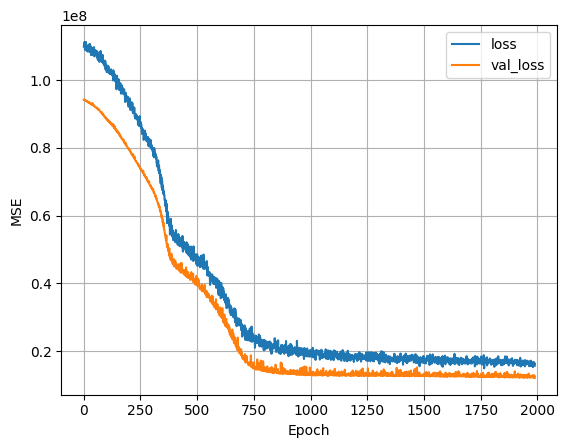

In [184]:
plot_loss(hist)

In [324]:
y_pred = model.predict(X_test)

21/21 [==============================] - 0s 7ms/step


In [325]:
y_pred = y_pred.reshape(-1, 1).flatten()

y_pred.shape, y_test.flatten().shape

((665,), (665,))

In [217]:
import datetime

def from_milis_to_date(milis):
    date = datetime.datetime.fromtimestamp(milis/1000.0).date()

    return f'{date.day}-{date.month}-{date.year}'

In [369]:
def plot_res(x, y, y_pred):
    plt.figure(figsize=(10,10))
    plt.scatter(x, y, s=5, label='True val')
    plt.scatter(x, y_pred, s=5, label='Pred')
    plt.legend()
    plt.grid(True)
    plt.show()

Dates from 25-1-2017 to 4-8-2020


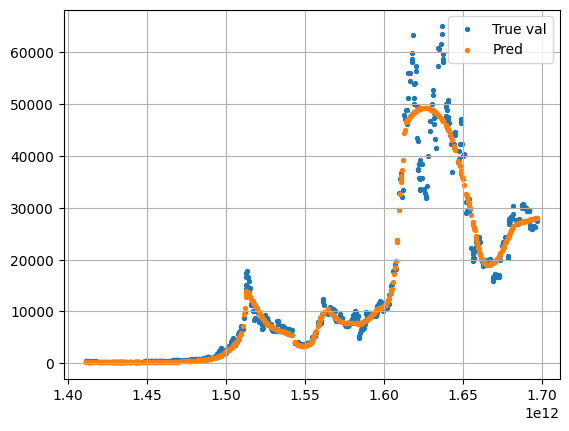

In [326]:
flat_x = X_test.flatten()
x0, xLast = flat_x[0].astype('int64'), flat_x[-1].astype('int64')
x0, xLast = from_milis_to_date(x0), from_milis_to_date(xLast)

print(f'Dates from {x0} to {xLast}')
plot_res(X_test, y_test.flatten(), y_pred)

In [378]:
df_since = df
_, new_y = df_since['date'], df_since['close'].values

new_y.shape

(3321,)

In [331]:
df['date'][0], len(df)

('1410901200000', 3321)

In [382]:
DATE = 1410901200000
new_x = np.array([DATE])

for i in range(len(df) + 3650):
    xLast = new_x[-1]
    new_val = xLast + DAY_IN_MILIS
    new_x = np.append(new_x, new_val)

if (len(new_x) - len(new_y)) > 0:
    print('Adding zeros')
    zeros = np.zeros(len(new_x) - len(new_y))
    new_y = np.append(new_y, zeros)

new_x.shape, new_y.shape


Adding zeros


((6972,), (6972,))

In [383]:
y_pred = model.predict(np.expand_dims(new_x, 1))
y_pred = y_pred.reshape(-1, 1).flatten()
y_pred.shape, new_x.shape, new_y.shape

  1/218 [..............................] - ETA: 7s

218/218 [==============================] - 1s 4ms/step


((6972,), (6972,), (6972,))

Dates from 17-9-2014 to 18-10-2033
Predicted price: [60177.543 60186.03  60194.527 60203.008 60211.484 60219.957 60228.43
 60236.902 60245.38  60253.844 60262.3   60270.76  60279.22  60287.684
 60296.133 60304.582 60313.027 60321.47  60329.914 60338.355 60346.8
 60355.22  60363.652 60372.086 60380.52 ]


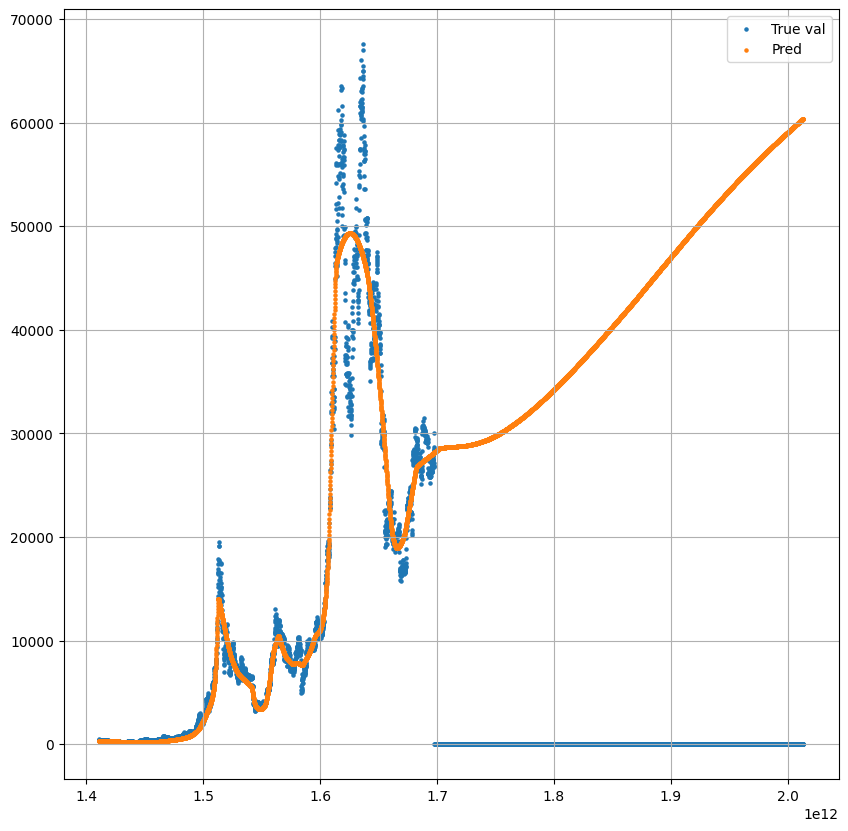

In [384]:
x0, xLast = from_milis_to_date(new_x[0]), from_milis_to_date(new_x[-1])

print(f'Dates from {x0} to {xLast}')
print(f'Predicted price: {y_pred[-25:]}')
plot_res(new_x, new_y, y_pred)

In [385]:
model.save('btc_price.h5')

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
